<a href="https://colab.research.google.com/github/Abhi-gola/Facial-keypoint/blob/main/face_Recognition_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!mkdir Val_data

In [5]:
import splitfolders
input_folder = '/content/drive/MyDrive/Datasets'

splitfolders.ratio(input_folder, output='Val_data',
                   ratio=(.7, .15, .15),
                   group_prefix=None)

Copying files: 6744 files [02:33, 43.83 files/s] 


In [6]:
import os
import cv2
sdir= r'/content/Val_data/train' 
ext='jpg' 
prefix='aug' 
batch_size=32 
passes=50 
datagen = ImageDataGenerator( rotation_range=20, width_shift_range=0.1, height_shift_range=0.2, shear_range = 0.2,
                                zoom_range = 0.1,  horizontal_flip=True, fill_mode = 'nearest')
data=datagen.flow_from_directory(directory = sdir, batch_size = batch_size,  target_size = (100, 100),
                                 color_mode = 'grayscale', shuffle=True)
for i in range (passes):
    images, labels=next(data)
    class_dict=data.class_indices
    new_dict={}
    # make a new dictionary with keys and values reversed
    for key, value in class_dict.items(): # dictionary is now {numeric class label: string of class_name}
        new_dict[value]=key    
    for j in range (len(labels)):                
        class_name = new_dict[np.argmax(labels[j])]         
        dir_path=os.path.join(sdir,class_name )         
        new_file=prefix + '-' +str(i*batch_size +j) + '.'  + ext       
        img_path=os.path.join(dir_path, new_file)        
        img=cv2.cvtColor(images[j], cv2.COLOR_BGR2RGB)
        cv2.imwrite(img_path, img)
print ('*** process complete')  

Found 4718 images belonging to 6 classes.
*** process complete


In [7]:
train = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=10,
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.1,
                                   zoom_range=0.25,
                                   horizontal_flip=False)

val = ImageDataGenerator(rescale=1./255.)
test = ImageDataGenerator(rescale=1./255.)

In [8]:
train_data = train.flow_from_directory(r'/content/Val_data/train', target_size=(100,100),
                                       batch_size=20, shuffle=True,
                                       class_mode="categorical", color_mode="grayscale")
val_data = val.flow_from_directory(r'/content/Val_data/val', target_size=(100,100),
                                       batch_size=20, shuffle=True,
                                       class_mode="categorical",color_mode="grayscale")
test_data = test.flow_from_directory(r'/content/Val_data/test', target_size=(100,100),
                                       batch_size=20, shuffle=True,
                                       class_mode="categorical",color_mode="grayscale")

Found 6318 images belonging to 6 classes.
Found 1010 images belonging to 6 classes.
Found 1016 images belonging to 6 classes.


In [9]:
(train_data[0][0][0]).shape

(100, 100, 1)

In [10]:
num_class = len(train_data.class_indices)
print(num_class)

6


In [11]:
model = Sequential()

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(100, 100, 1)))
model.add(BatchNormalization()) #----------------
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization()) #----------------
model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization()) #----------------
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2)) #----------------

model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(num_class, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        102464    
                                                                 
 batch_normalization_2 (Batc  (None, 96, 96, 64)       2

In [12]:
learning_rate = 0.001
optimizer = RMSprop(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=12,
                                            verbose=1,
                                            factor=0.2, min_lr=1e-6)

ch = ModelCheckpoint('models/'+'face'+'.h5', monitor='val_acc', verbose=0, save_best_only=True, mode='max')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=200)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/"+datetime.now().strftime("%Y%m%d-%H%M%S"))

In [14]:
import os
total_samples = 0
for root_dir, cur_dir, files in os.walk(r'/content/Val_data/train'):
    total_samples += len(files)
print(total_samples)

6318


In [15]:
epochs = 70
batch_size = 256
history = model.fit(train_data,
                              steps_per_epoch= total_samples//batch_size,
                              epochs=epochs,
                              validation_data=val_data,
                              validation_steps=50,
                              verbose = 1,
                              callbacks=[learning_rate_reduction, es, ch])

Epoch 1/70
24/24 [==============================] - 22s 151ms/step - loss: 1.3546 - acc: 0.5896 - val_loss: 4.9781 - val_acc: 0.1490 - lr: 0.0010
Epoch 2/70
24/24 [==============================] - 3s 131ms/step - loss: 0.6497 - acc: 0.7875 - val_loss: 60.5456 - val_acc: 0.1430 - lr: 0.0010
Epoch 3/70
24/24 [==============================] - 3s 127ms/step - loss: 0.5501 - acc: 0.8083 - val_loss: 8.0211 - val_acc: 0.0660 - lr: 0.0010
Epoch 4/70
24/24 [==============================] - 3s 126ms/step - loss: 0.5770 - acc: 0.8104 - val_loss: 90.1546 - val_acc: 0.1430 - lr: 0.0010
Epoch 5/70
24/24 [==============================] - 3s 134ms/step - loss: 0.4108 - acc: 0.8750 - val_loss: 106.9474 - val_acc: 0.1380 - lr: 0.0010
Epoch 6/70
24/24 [==============================] - 3s 141ms/step - loss: 0.5184 - acc: 0.8562 - val_loss: 65.7927 - val_acc: 0.1430 - lr: 0.0010
Epoch 7/70
24/24 [==============================] - 3s 124ms/step - loss: 0.3679 - acc: 0.8854 - val_loss: 78.0768 - val_acc

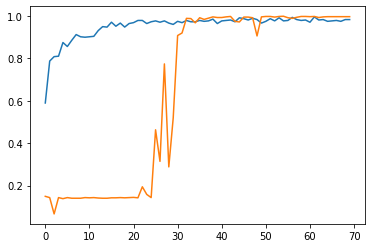

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(70)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

In [17]:
loss, acc = model.evaluate(val_data)

print(f'Loss: {loss}\nAccuracy: {acc*100}')

51/51 [==============================] - 1s 28ms/step - loss: 0.0141 - acc: 0.9970
Loss: 0.014112967997789383
Accuracy: 99.7029721736908


In [18]:
loss, acc = model.evaluate(test_data)

print(f'Loss: {loss}\nAccuracy: {acc*100}')

51/51 [==============================] - 2s 30ms/step - loss: 0.0047 - acc: 0.9980
Loss: 0.004722184501588345
Accuracy: 99.8031497001648
